In [1]:
suppressMessages(library(limma))
suppressMessages(library(jsonlite))
suppressMessages(library(progress))
suppressMessages(library(gplots))
suppressMessages(library(dplyr))
suppressMessages(library(metafor))
suppressMessages(library(ggplot2))
suppressMessages(library(org.Mm.eg.db))
suppressMessages(library(annotate))
suppressMessages(library(mygene))
suppressMessages(require("biomaRt"))
#suppressMessages(library(gCMAP))
#suppressMessages(library('qusage'))
#suppressMessages(library(TMixClust))


### FUNCTIONS
source("./post_functions/FUN.Run_functional_GSEA.R")
source("./utils/gather.R")
source("./utils/mouse2human.R")
source("./utils/varplot.R")
source("./utils/get_slopes.R")
source("./plot_functions/corplot.R")
source("./plot_functions/FUN.Visualize_GSEA_heatmap.R")
source("./plot_functions/ggcorplot.R")
source("./plot_functions/plot_dynamics.R")
source("./plot_functions/plot_volcano.R")
source("./plot_functions/plot_venn.R")
source('plot_functions/gene_barplot.R')
source('plot_functions/plot_contingency.R')
source('plot_functions/plot_contingency_pair.R')

#OPTIONS
options(warn=-1) #no warnings -1; yes warnings 0
WIDTH = 21.0 #cm

# Panel 1

## Mouse

In [17]:
# show how signature correlates with datasets

### get all needed data
signature_mouse <- read.csv('signatures/reprogramming_mouse_full.csv', row.names=1)
signature_human <- read.csv('signatures/reprogramming_human_full.csv', row.names=1)
signature_humanEtz <- read.csv('signatures/reprogramming_human_full_humanEntrez.csv', row.names=1)
signature_mouse_human <- read.csv('signatures/reprogramming_human_mouse_full.csv', row.names=1)

datasets <- c('GSE67462$OSKM','GSE38509$OSKM','GSE38509$OSK',
              'GSE116309$OKMS', 'GSE116309$OK+9MS', 'GSE46321$C/EBPα+ OSKM', 
              'GSE114581$OSKM+dox_mef', 'GSE21757$OKMS',
              'GSE127927$7F-Esrrb', 'GSE127927$7F-Glis1', 'GSE127927$7F-Jdp2', 
              'GSE127927$7F-Kdm2b', 'GSE127927$7F-Mkk6', 'GSE127927$7F-Nanog', 
              'GSE127927$7F-Sall4', 'GSE127927$7F', 
              'GSE102348$OSKM$Gatad2a-/-', 'GSE102348$OSKM$Mbd3f/-', 'GSE102348$OSKM$WT-1')

# taken from kit standard of 
#https://www.clinisciences.com/en/read/stem-cells-characterization-1087/esc-and-ipsc-characterization-by-1429.html
#and https://www.nature.com/articles/s41598-018-24051-5
pluripotency_mouse <- c('20674', '18999', '71950', '26380', '18613', '81879', '11614', 
                        '22773', '52463', '14562', '22286', '54427', '13436', '17075',
                        '16468', '21420', '50764', '12550', '11647', '636931', '11545',
                        '12349','12443','12444','12447','12575','12578','13435',
                        '13841','14175','14472','16447','16664','16666',
                        '17218','20617','20753','21667','22702','26447',
                        '27205','53972','54427','106344') #mouse Etz

ultradf <- fromJSON("./data/ultradf_v4.json")

#parsing
for (i in names(ultradf)) {
    df <- read.csv(text=ultradf[[i]]$data, row.names=2)[, -1]
    pheno <- read.csv(text=ultradf[[i]]$pheno)
    stopifnot(nrow(pheno)==ncol(df))
    ultradf[[i]]$data <- df
    ultradf[[i]]$pheno <- pheno
}
ultradf <- ultradf[datasets]

tmp_result <- get_slopes(ultradf, stoplist=c(), genelist=c())
datasets_list <- tmp_result[['datasets']]
slopes <- tmp_result[['slopes']]

combined <- c(list("Reprogramming:Mouse"=signature_mouse), datasets_list)

GSE67462$OSKM Pheno: 16 Total: 20479 Passed: 5469 
GSE38509$OSKM Pheno: 18 Total: 20955 Passed: 5255 
GSE38509$OSK Pheno: 6 Total: 20955 Passed: 1050 
GSE116309$OKMS Pheno: 4 Total: 20955 Passed: 0 
GSE116309$OK+9MS Pheno: 4 Total: 20955 Passed: 1253 
GSE46321$C/EBPα+ OSKM Pheno: 18 Total: 22036 Passed: 10185 
GSE114581$OSKM+dox_mef Pheno: 9 Total: 13063 Passed: 3108 
GSE21757$OKMS Pheno: 7 Total: 16480 Passed: 1815 
GSE127927$7F-Esrrb Pheno: 5 Total: 12080 Passed: 541 
GSE127927$7F-Glis1 Pheno: 5 Total: 12080 Passed: 46 
GSE127927$7F-Jdp2 Pheno: 5 Total: 12080 Passed: 19 
GSE127927$7F-Kdm2b Pheno: 5 Total: 12080 Passed: 359 
GSE127927$7F-Mkk6 Pheno: 5 Total: 12080 Passed: 0 
GSE127927$7F-Nanog Pheno: 5 Total: 12080 Passed: 0 
GSE127927$7F-Sall4 Pheno: 5 Total: 12080 Passed: 0 
GSE127927$7F Pheno: 10 Total: 12080 Passed: 3286 
GSE102348$OSKM$Gatad2a-/- Pheno: 9 Total: 11132 Passed: 3346 
GSE102348$OSKM$Mbd3f/- Pheno: 9 Total: 11132 Passed: 2738 
GSE102348$OSKM$WT-1 Pheno: 5 Total: 1113

In [69]:
source("./plot_functions/ggcorplot.R")
source("./plot_functions/plot_dynamics.R")
source("./plot_functions/plot_volcano.R")
source('plot_functions/plot_contingency_pair.R')

gA <- ggheatmap(combined, 
                type='pairwise_top', method='spearman', top=350, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="logFC", criterion="FDR",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                fontsize = 20,  scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete")

gB <- plot_dynamics(signature_mouse, ultradf, top=5, interval=2)
gC <- plot_volcano(signature_mouse, pluripotency=pluripotency_mouse, fdr_thr=0.001, coef_thr=c(-2.5, 2.5),)
gD <- plot_contingency_pair(signature_mouse, signature_human, suf1='Mouse', suf2='Human')

uprow <- cowplot::plot_grid(gA, gC, ncol=1, labels = c("B", "D"), label_size = 32, rel_heights = c(3, 1.5))
dwrow <- cowplot::plot_grid(gB, gD, ncol=1, labels = c("C", "E"), label_size = 32, rel_heights = c(3, 1.5))
P <- cowplot::plot_grid(uprow, dwrow, nrow=1, label_size = 32, rel_widths = c(3, 1.8))

ggsave('figs/panel1.pdf', P, width=WIDTH, height=17.0, units = "cm", dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables



## Human

In [ ]:
#datasets <- c('GSE89455$OSKM$HDF', 'GSE89455$OSKM$HAdMSC', 'GSE89455$OSKM$HA', 
#              'GSE89455$OSKM$HBEC','GSE89455$OSKM$HPrEC','GSE50206$OSKM$HDF',
#              'GSE50206$OSKM$ASC','GSE50206$OSKM$HA','GSE50206$OSKM$NHBE',
#              'GSE50206$OSKM$PrEC','GSE54848$OSKM$HDF')
#ultradf <- fromJSON("./data/ultradf_human_v3.json") #ultradf_human is always with human EntrezID

#combined <- c(list("Reprogramming:Human"=signature_humanEtz), datasets_list)

In [ ]:
#pluripotency_human <- c('5460') #human Etz
#gB <- plot_dynamics(signature_humanEtz, ultradf, top=5, interval=2)

#gC <- plot_volcano(signature_humanEtz, pluripotency=pluripotency_human, fdr_thr=0.01, coef_thr=4.0,
#                     xlim=c(-7,7))
#gD <- plot_volcano(signature_mouse_human, pluripotency_mouse, fdr_thr=0.0001, coef_thr=3.0)

# Panel 2

In [107]:
# show how signature correlates with datasets

### get all needed data
signature_mouse <- read.csv('signatures/reprogramming_mouse_full.csv', row.names=1)
signature_human <- read.csv('signatures/reprogramming_human_full.csv', row.names=1)
signature_humanEtz <- read.csv('signatures/reprogramming_human_full_humanEntrez.csv', row.names=1)
signature_mouse_human <- read.csv('signatures/reprogramming_human_mouse_full.csv', row.names=1)

combined_full_rep <- readRDS('signatures/combined_full_rep.rds')

In [109]:
source("./plot_functions/ggcorplot.R")
source('plot_functions/gene_barplot.R')
source('plot_functions/plot_contingency.R')

gA <- ggheatmap(combined_full_rep, 
                type='pairwise_top', method='spearman', top=350, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="logFC", criterion="FDR",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                fontsize = 20,  scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete")

gene_interest <- c('Igf1', 'Rela', 'Rragc', 'Mrpl11', 'Trappc6a', 'Hsd17b12', 'Uqcrq')
#gene_interest <- c('Mmp9', 'Gadd45a', 'Itpr3', 'Bmp2', 'Igfbp3', 'Sesn2', 'Ptges', 'Fos')
gB <- gene_barplot(combined_full_rep, gene_interest)


gC1 <- plot_contingency(combined_full_rep, 'Interventions', lims=c())
gC2 <- plot_contingency(combined_full_rep, 'Aging', lims=c(-37, 37), textcol='black')
gC <- cowplot::plot_grid(gC1, gC2, labels=c('C', ''), ncol=2, nrow=1, 
                            label_size = 32, rel_heights = c(2, 2))

left <- cowplot::plot_grid(gA, gC, labels=c('A', 'C'), ncol=1, nrow=2, 
                            label_size = 32, rel_heights = c(4, 2))
P2 <- cowplot::plot_grid(left, gB, labels=c('', 'B'), ncol=2, nrow=1, 
                            label_size = 32, rel_widths = c(3, 2))

ggsave('figs/panel2.pdf', P2, width=WIDTH, height=17.0, units = "cm", dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables



In [13]:
X <- signature_mouse
Y <- signature_human
X <- X[X$FDR < 0.05,]
Y <- Y[Y$FDR < 0.05,]

sub <- merge(X, Y, by=0)
col1 <- "logFC.x"
col2 <- "logFC.y"
urua <- length(sub[(sub[[col1]] > 0) & (sub[[col2]] > 0),]$Row.names)
urda <- length(sub[(sub[[col1]] < 0) & (sub[[col2]] > 0),]$Row.names)
drua <- length(sub[(sub[[col1]] > 0) & (sub[[col2]] < 0),]$Row.names)
drda <- length(sub[(sub[[col1]] < 0) & (sub[[col2]] < 0),]$Row.names)

if (all(c(urua, urda, drua, drda)) == T){
    #test for distribution randomness
    cont_table <- cbind(c(urua, drua), 
                        c(urda, drda))
    test <- chisq.test(cont_table)
    pval <- test$p.val
}

data <- as.matrix(test$observed)
data

547,141
142,756


# Panel 3

In [2]:
gsea <-readRDS("gsea_results/fgsea_results_All.rds")
#make all pathways as indices
for (name in names(gsea)){
    gsea[[name]] <- as.data.frame(gsea[[name]])
    rownames(gsea[[name]]) <- gsea[[name]]$pathway
}

clockm <- read.csv('clocks/Mouse_clock_output.csv', row.names=1)
clockh <- read.csv('clocks/Human_clock_output.csv', row.names=1)
gef <- read.csv('clocks/gene_effects.csv')
gref <- read.csv('clocks/group_effects.csv')

In [12]:
#corplot + hallmark
source('plot_functions/plot_hallmark.R')
source("./plot_functions/ggcorplot_hallmark.R")
source('plot_functions/plot_all_clocks.R')
source('plot_functions/plot_group_clocks.R')
source('plot_functions/plot_gene_effects.R')
source('plot_functions/plot_group_effects.R')


tmpplot <- ggheatmap_hallmark(gsea, 
                type='pairwise_top', method='spearman', top=500, pvplot=F,
                label_size=1.2, value_size=0.8, title="Spearman correlation",
                measure="NES", criterion="padj",
                orderCol = T, orderRow = T, dendroLineSize = 0.5,
                scaleName = "value",
                distMethod = "euclidean", clustMethod = "complete", 
                scale_name="NES \nSpearman \ncorrelation ")

gA <- tmpplot[['A']]
gB <- tmpplot[['B']]
gC <- plot_group_clocks(clockm, clockh)
gE <- plot_gene_effects(gef, 15)
gF <- plot_group_effects(gref)

left <- cowplot::plot_grid(gA, gB, labels=c("A", "B"), label_size = 32, ncol=1, align='v', 
                           rel_heights = c(2, 3))

top <- cowplot::plot_grid(left, gC, label_size = 32, ncol=2, rel_widths = c(2, 1))
bottom <-cowplot::plot_grid(gE, gF, labels=c("E", "F"), label_size = 32, ncol=2, rel_widths = c(2.6, 1))
P3 <- cowplot::plot_grid(top, bottom, label_size = 32, nrow=2, rel_heights = c(4, 1))

ggsave('figs/panel3.pdf', P3, units = "cm", width=WIDTH, height=27.0, dpi=300, scale=2.5)

Using rowname as id variables

Using rowname as id variables

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`summarise()` ungrouping output (override with `.groups` argument)



In [68]:
source('plot_functions/plot_all_clocks.R')
PS3 <- plot_all_clocks(clockm, clockh)
ggsave('figs/panelS3.pdf', PS3, units = "cm", width=WIDTH, height=24., dpi=300, scale=2.5)

`summarise()` ungrouping output (override with `.groups` argument)



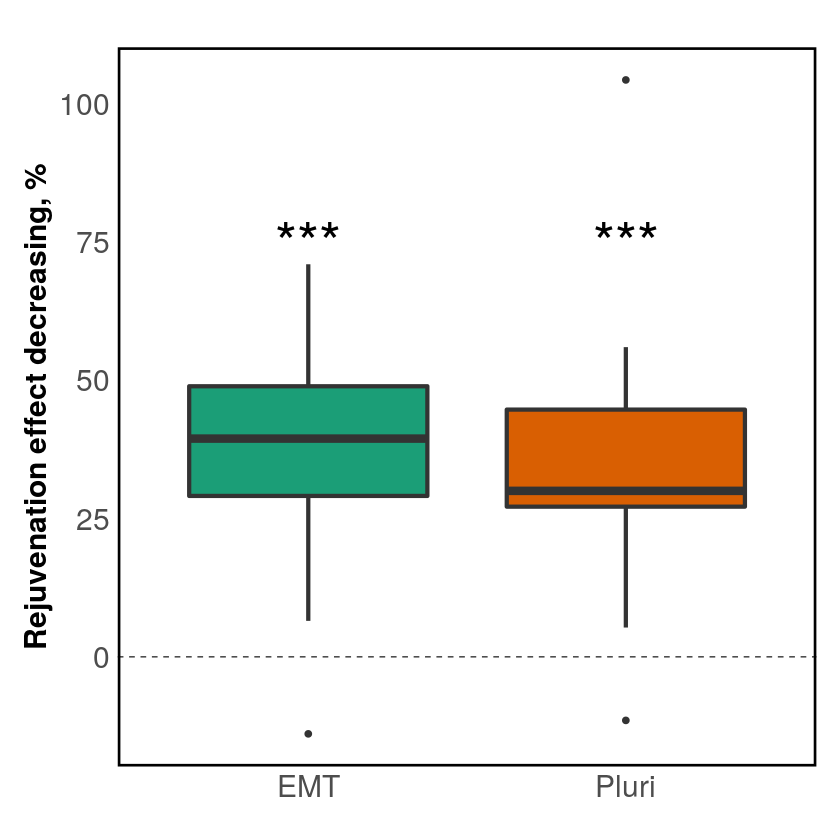

In [349]:
# plot_gene_effects <- function(gef, top=10, thr=0.05, fontsize=18){
# agef <- aggregate(.~symbol, gef, FUN="mean")[,c("symbol", "knockout_effect", "FDR")]
# gef$star <- as.character(gef$star)
# agef['star']<- aggregate(.~symbol, gef, FUN=function(x){x[[1]]})[,c("symbol", "star")]$star
# agef <- agef[agef$FDR < 0.05,]

# selected_agef <- agef[order(agef$knockout_effect, decreasing=T),][1:top,]
# selected <- selected_agef$symbol
# selected_mean <- selected_agef$knockout_effect
# selected_star <- selected_agef$star
# sgef <- gef[gef$symbol %in% selected,]
# sgef$symbol <- factor(sgef$symbol, levels=selected)

# p <- ggplot(data=sgef, aes(x=symbol, y=knockout_effect)) +
#         geom_boxplot(aes(fill=symbol), alpha = 0.8, outlier.shape = NA, lwd=1.2) + 
#         #scale_fill_viridis(discrete = TRUE, alpha=0.6, option="H")+
#         #scale_fill_manual(values = cols)+
#         scale_fill_brewer(palette='Purples')+
#         geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.4, alpha=0.8)+
#         geom_point(aes(fill='black'), alpha=0.4, size = 1., position = position_jitterdodge(0.1))+
#         geom_text(data=data.frame(), aes(label=selected_star, x=selected, y=selected_mean), 
#         vjust=-4.0, fontface='bold', size=7, color='black')+
#         theme(  axis.text=element_text(size=fontsize),
#         axis.title=element_text(size=fontsize, face="bold"),
#         panel.background = element_rect(fill='white', colour='black', size=1.5, linetype='solid'),
#         panel.grid.major = element_blank(),
#         panel.grid.minor = element_blank(),
#         legend.position = "none",
#         plot.margin = unit(c(1,1,0,0.5), "cm")) +
#         labs(x = "", y = "Rejuvenation effect decreasing, %")
#         return(p)
# }

# Panel 4

In [23]:
# gA <- cowplot::ggdraw() + cowplot::draw_image("figs/panel1/Mouse average dynamics_cluster_heatmap.svg", scale = 1)
# gB <- cowplot::ggdraw() + cowplot::draw_image("figs/panel1/Mouse average dynamics_cluster_dynamics.svg", scale = 1)
# p2 <- cowplot::ggdraw() + cowplot::draw_image("http://jeroen.github.io/images/tiger.svg", scale = 0.9)
# cowplot::plot_grid(gA, gB, p2, labels = "AUTO")

# Panel 5

# Garbage collector

In [30]:
# SL <- list()
# cols <- c('NES', 'pval', 'padj')
# types <- c(rep('Reprogramming',3), rep('Interventions',6), rep('Aging', 7))

# for (col in cols){
#     SL[[col]] <- data.frame(row.names=rownames(gsea[[1]]))
#     for (name in names(gsea)){
#             tmp <- gsea[[name]][col]
#             colnames(tmp) <- c(name)
#             SL[[col]] <- transform(merge(SL[[col]], tmp, 
#                                                 by=0, sort=F,), 
#                                                 row.names=Row.names, Row.names=NULL)
#     }
# }

# tmpdf <- gsea[[1]]

In [73]:
#asub <- SL[['pval']][, types=='Aging']
#as.vector(apply(asub, 1, gmean)

In [110]:
# # top <- 5
# gmean <- function(x) exp(mean(log(x)))
# # gm = as.data.frame(list('gmean'=apply(SL[['P.Value']], 1, gmean )))
# # gm <- rownames(gm[order(gm$gmean),, drop=FALSE])[1:top]

# #gmean
# asub <- SL[['padj']][, types=='Aging']
# GM <- as.vector(apply(asub, 1, gmean))
# asub <- (GM < 0.05)

# isub <- SL[['padj']][, types=='Interventions']
# GM <- as.vector(apply(isub, 1, gmean))
# isub <- (GM < 0.05)

# rsub <- SL[['padj']][, types=='Reprogramming']
# GM <- as.vector(apply(rsub, 1, gmean))
# rsub <- (GM < 0.05)

# #mean
# amub <- SL[['NES']][, types=='Aging']
# GM <- as.vector(apply(amub, 1, mean))
# amub <- (GM > 0.)

# imub <- SL[['NES']][, types=='Interventions']
# GM <- as.vector(apply(imub, 1, mean))
# imub <- (GM < 0.)

# rmub <- SL[['NES']][, types=='Reprogramming']
# GM <- as.vector(apply(rmub, 1, mean))
# rmub <- (GM < 0.)

# direction_cond <- asub & rsub & amub & imub & rmub


# cond <- SL[['padj']][direction_cond,]
# cond_filt <- cond[order(cond$Reprogramming.Mouse),]
# accepted <- rownames(cond_filt)
# length(accepted)

[1] 69

In [113]:
# #func_interest <- accepted[1:6]
# func_interest <- c('GOBP_ATP_METABOLIC_PROCESS', 
#                    'KEGG_RIBOSOME',
#                    'REACTOME_MITOCHONDRIAL_TRANSLATION')

In [43]:
# melter <- data.frame()
# for (f in func_interest){
#         #func for mapping stars
#         plab <- function(p )ifelse(p<0.001,'***', ifelse(p<0.01,'**', ifelse(p<0.05,'*',''))) 

#         #rescale columns
#         tmpLogFC <- SL[['NES']] #/ apply(SL[['NES']], 2, sd)

#         mel <- t(tmpLogFC[f,])
#         mel <- transform(merge(mel,  t(SL[['pval']][f,]), by=0, sort=F), 
#                                         row.names=Row.names, Row.names=NULL)
#         mel <- merge(mel,  t(SL[['padj']][f,]), by=0, sort=F)
#         mel$Function <- rep(f, nrow(mel))
#         colnames(mel) <- c('Signature', 'NES', 'Pval', 'Padj', 'Function')
#         mel$Type <- types
#         mel$Signature <- factor(as.character(mel$Signature), levels=unique(as.character(mel$Signature)))
#         mel$Star <- plab(mel$Padj)
#         mel$Vjust <- if_else(mel$NES > 0, 0.2, 1.1)
#         # mel$Symbol <- rep(sym, nrow(mel))
#         melter <- rbind(melter, mel)
# }

# #plot
# options(repr.plot.width = 10, repr.plot.height = 16)
# g <- ggplot(melter, aes(x=Signature, y=NES, fill=Type))+ 
#         geom_bar(stat="identity") +
#         facet_wrap(~Function, ncol=1, scales = "free_y", dir="v") + 
#         geom_text(aes(label=Star, vjust=melter$Vjust, hjust=0.5), fontface='bold', size=7)+
#         #geom_errorbar(aes(ymin=Coef-SE, ymax=Coef+SE), width=0.18) + 
#         theme(axis.text=element_text(size=14, angle=45, hjust=1),
#                 strip.background = element_blank(),
#                 strip.placement = 'inside',
#                 strip.text = element_text(colour = 'black', size=16, face="bold", hjust = 0.5),     
#                 axis.title=element_text(size=18, face="bold"), 
#                 plot.title=element_text(size = 20, face = "bold"),
#                 legend.title=element_text(size=16, face = "bold"),
#                 legend.text=element_text(size=14),
#                 legend.position="top",
#                 panel.background = element_rect(fill='white', colour='black', size=1.1, linetype='solid'),
#                 panel.grid.major = element_blank(),
#                 panel.grid.minor = element_blank(),
#                 plot.margin = unit(c(0.5,0.5,0.5,0.), "cm")) +
#                 labs(x = "", y = "NES")+
#                 expand_limits(y=c(-3, 3))
# g
